<a href="https://colab.research.google.com/github/keisuke6616/Correlation-tests-for-high-dimensional-data/blob/master/Figure1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import numpy.linalg as la

from scipy.stats import norm
import matplotlib.pyplot as plt 


import time

# Figure 1

In [0]:
t1 = time.time()
np.random.seed(42)

N = [10, 20, 40, 80]
P = [20, 100, 500, 2500]
index = [i for i in range(len(N))]

iter = 2000
u = np.zeros(len(N))
omg = np.zeros(len(N))
result = np.zeros((len(N), 2, iter))

for n, p, pc in zip(N, P, index):
    print('Dimension : {}, Size : {}'.format(p, n))
    mu = np.zeros(p)
    Sigma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Sigma[i, j] =0.3**(np.abs(i - j)**(1/3))
    value, vec = SortEig(Sigma)
    Gamma = np.sqrt(value).reshape(-1, p) * vec
    
    c_1 = [0 for i in range(p)] + [1]
    c_2 = [np.sqrt(1 / 20) for i in range(10)] + [0 for i in range(p - 10)] + [np.sqrt(1 / 2)]
    c = [c_1, c_2]
    
    trS = np.trace(np.dot(Sigma, Sigma))
    sigma = np.sum(c[1][i] * Gamma.T[i] for i in range(p))
    u[pc] = 2 * n * (np.einsum('i, ij, j', sigma, Sigma, sigma) + la.norm(sigma)**4) / trS
    omg[pc] = la.norm(sigma)**2 / (np.sqrt(2 * trS) / n)
    
    
    for l in range(iter):
        W= np.random.normal(0, 1, (n, p))
        X = np.dot(W, Gamma.T)
        
        w = np.random.normal(0, 1, n)
        x = np.zeros(n)
        for k in range(2):
            for j in range(n):
                x[j] = np.sum(c[k][i] * W[j, i] for i in range(p)) + c[k][p] * w[j]

            S = np.var(x, ddof=1)    
            result[pc, k, l] = T_hat(X, x) / (S * np.sqrt(2 * ECDM(X)) / n)
            
        
    
t2 = time.time()
print('')
print('Calcuration time : {}'.format(t2 - t1))


Dimension : 20, Size : 10
Dimension : 100, Size : 20
Dimension : 500, Size : 40
Dimension : 2500, Size : 80

Calcuration time : 1871.5503103733063


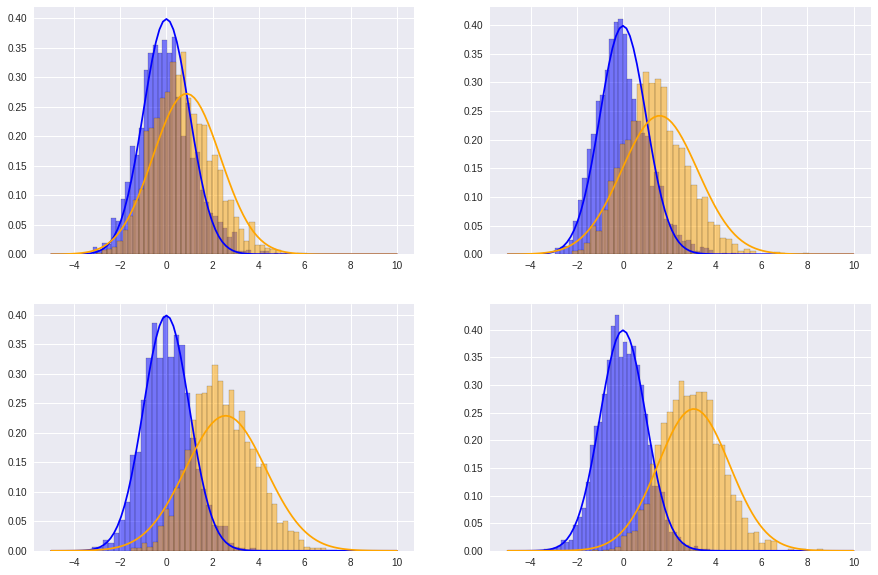

In [0]:
pl = np.linspace(-5, 10, 100)
plt.figure(figsize = (15, 10))

color_list=['blue', 'orange']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(pl, norm.pdf(pl, loc=0, scale=1), color='blue')
    plt.plot(pl, norm.pdf(pl, loc=omg[i], scale=np.sqrt(1+u[i])), color='orange')
    plt.hist(result[i, 0], bins=40, alpha=.5, normed=True, ec='black', color='blue')
    plt.hist(result[i, 1], bins=40, alpha=.5, normed=True, ec='black', color='orange')
    

# Function

## Create ${\hat{T}_{n, \sigma}}$

In [0]:
def T_hat(X, x):
    N, p = X.shape
    
    n = []
    n.append(int(np.ceil(N / 2)))
    n.append(N - n[0])
    
    K = [i for i in range(3, 2*N)]
    index =  [i for i in range(len(K))]

    
    V = [[], []]
    Y = np.zeros((2, len(K), p))
    y = np.zeros((2, len(K)))
    for k, pc in zip(K, index):
        dv = int(np.floor(k / 2))

        if dv < n[0]:
            V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
        else:
            V[0].append([i for i in range(dv - n[0], dv)])

        if dv <= n[0]:
            V[1].append([i for i in range(dv, dv + n[1])])
        else:
            V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])
           
        for i in range(2):
            Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
            y[i, pc] = np.sum(x[V[i][pc]]) / n[i]
            
    w = 0
    for j in range(N):
        for i in range(j):
            w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) * (x[i] - y[0][i + j - 1]) * (x[j] - y[1][i + j - 1])

    u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
    T = 2 * u / (N * (N - 1)) * w
    
    return T

## ECDM

In [0]:
import numpy as np

def ECDM(X):
    N, p = X.shape
    
    n = []
    n.append(int(np.ceil(N / 2)))
    n.append(N - n[0])
    
    K = [i for i in range(3, 2*N)]
    index =  [i for i in range(len(K))]

    
    V = [[], []]
    Y = np.zeros((2, len(K), p))
    for k, pc in zip(K, index):
        dv = int(np.floor(k / 2))

        if dv < n[0]:
            V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
        else:
            V[0].append([i for i in range(dv - n[0], dv)])

        if dv <= n[0]:
            V[1].append([i for i in range(dv, dv + n[1])])
        else:
            V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])
           
        for i in range(2):
            Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
            
    w = 0
    for j in range(N):
        for i in range(j):
            w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) ** 2

    u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
    W = 2 * u / (N * (N - 1)) * w

    return W

## SortEig

In [0]:
import numpy as np
import numpy.linalg as la

def SortEig(X):
    value, vec = la.eig(X)
    idx = value.argsort()[::-1]
    P = value[idx]
    Q = vec.T[idx]
       
    return(P, Q.T)